# ITU-T P.1203 Model Fine-Tuning

Based on our subjective testing data

# Notes

**07.11**
Previously the bitrate was used in mbits/second
Now the p1203 model clearly uses kbits/second

I am collecting all video bitrates in bytes and then converting them to mbits/second, before multiplying them by 1000 to get kbits/second
I am also only storing the bitrate in kbits to avoid confusion

The way to get the megabits values is:
1. get the size of the bin file in bytes (or kilobytes)
2. convert it to megabits by dividing by 125000
3. divide it by 10 (since the bin file is for 10-seconds) to get megabits / second
4. multiply it by 1000 to get kbit/s
All of our sequences are 10-second sequences, thus we divide by 10

The video bitrates are as follows:

#### VPCC
```
BlueSpin-r1.bin: 14000.33 kilobits
BlueSpin-r2.bin: 18358.77 kilobits
BlueSpin-r3.bin: 25381.74 kilobits
BlueSpin-r4.bin: 60218.56 kilobits
BlueSpin-r5.bin: 100957.13 kilobits
CasualSquat-r1.bin: 20028.41 kilobits
CasualSquat-r2.bin: 31350.91 kilobits
CasualSquat-r3.bin: 53280.41 kilobits
CasualSquat-r4.bin: 156102.30 kilobits
CasualSquat-r5.bin: 248934.89 kilobits
FlowerDance-r1.bin: 21305.45 kilobits
FlowerDance-r2.bin: 33934.77 kilobits
FlowerDance-r3.bin: 57028.55 kilobits
FlowerDance-r4.bin: 182492.95 kilobits
FlowerDance-r5.bin: 314833.07 kilobits
```

#### GPCC OCTREE PREDLIFT
```
BlueSpin	GPCC_OCTREE	r03: 13660.416000000001
BlueSpin	GPCC_OCTREE	r04: 46060.824
BlueSpin	GPCC_OCTREE	r05: 109881.408
FlowerDance	GPCC_OCTREE	r03: 19756.144
FlowerDance	GPCC_OCTREE	r04: 86391.176
FlowerDance	GPCC_OCTREE	r05: 250931.52000000002
CasualSquat	GPCC_OCTREE	r03: 17925.864
CasualSquat	GPCC_OCTREE	r04: 80444.512
CasualSquat	GPCC_OCTREE	r05: 236568.048
ReadyForWinter	GPCC_OCTREE	r03: 15638.336000000001
ReadyForWinter	GPCC_OCTREE	r04: 52875.8
ReadyForWinter	GPCC_OCTREE	r05: 134155.064
```

#### GPCC TRISOUP RAHT
```
BlueSpin	GPCC_TRISOUP	r01: 9943.304
BlueSpin	GPCC_TRISOUP	r02: 21686.392
BlueSpin	GPCC_TRISOUP	r03: 48736.448000000004
BlueSpin	GPCC_TRISOUP	r04: 109806.632
FlowerDance	GPCC_TRISOUP	r01: 30262.008
FlowerDance	GPCC_TRISOUP	r02: 80246.72
FlowerDance	GPCC_TRISOUP	r03: 190894.312
FlowerDance	GPCC_TRISOUP	r04: 399077.4
CasualSquat	GPCC_TRISOUP	r01: 38344.168
CasualSquat	GPCC_TRISOUP	r02: 92561.18400000001
CasualSquat	GPCC_TRISOUP	r03: 197146.93600000002
CasualSquat	GPCC_TRISOUP	r04: 387772.944
ReadyForWinter	GPCC_TRISOUP	r01: 9973.616
ReadyForWinter	GPCC_TRISOUP	r02: 22938.344
ReadyForWinter	GPCC_TRISOUP	r03: 60035.200000000004
ReadyForWinter	GPCC_TRISOUP	r04: 142426.24
```

#### OLD VIDEOS
```
longdress-r1.bin: 45330.51 kilobits
longdress-r3.bin: 137209.71 kilobits
longdress-r5.bin: 456825.40 kilobits
loot-r1.bin: 22223.74 kilobits
loot-r3.bin: 54941.94 kilobits
loot-r5.bin: 162842.81 kilobits
ReadyForWinter-r1.bin: 15823.20 kilobits
ReadyForWinter-r2.bin: 20687.30 kilobits
ReadyForWinter-r3.bin: 28919.76 kilobits
ReadyForWinter-r4.bin: 74742.73 kilobits
ReadyForWinter-r5.bin: 132748.28 kilobits
redandblack-r1.bin: 33068.13 kilobits
redandblack-r3.bin: 73753.55 kilobits
redandblack-r5.bin: 223673.06 kilobits
soldier-r1.bin: 42745.16 kilobits
soldier-r3.bin: 113102.48 kilobits
soldier-r5.bin: 344626.97 kilobits
```

# Imports

In [125]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203 import P1203Standalone
from itu_p1203 import P1203Pq
from itu_p1203 import P1203Pa
from itu_p1203 import P1203Pv
from itertools import permutations
import json
import os
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping, brute, shgo, dual_annealing, direct
from enum import Enum


# Universal Data

## Video Metadata

In [126]:
# User QoE Scores CSV File
#qoe_csv_filepath = './results/test_scores.csv'
qoe_csv_filepath = './results/test_scores_only_compeq.csv'
results_folder = "./results_shivi"
error_data_folder="./Error_Data"


# Bitrate and resolution information for all the videos in KBPS

# New aka ComPEQ-MR Dataset
bitrates_kbps_new_vpcc = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

bitrates_kbps_new_gpcc_octree = {
    'BlueSpin': {'r03': 13660.42, 'r04': 46060.82, 'r05': 109881.41},
    'CasualSquat':  {'r03': 17925.86, 'r04': 80444.51, 'r05': 236568.05},
    'ReadyForWinter': {  'r03': 15638.37, 'r04': 52875.8, 'r05': 134155.06 },
    'FlowerDance': { 'r03': 19756.14, 'r04': 86391.18, 'r05': 250931.52}
}

bitrates_kbps_new_gpcc_trisoup = {
    'BlueSpin': {'r01': 9943.30, 'r02': 21686.40, 'r03': 48736.45, 'r04': 109806.63},
    'CasualSquat':  {'r01': 38344.17, 'r02': 92561.18, 'r03': 197146.94, 'r04': 387772.944},
    'ReadyForWinter': { 'r01': 9973.62, 'r02': 22938.34, 'r03': 60035.20, 'r04': 142426.24 },
    'FlowerDance': { 'r01': 30262.01,  'r02': 80246.72,  'r03': 190894.31, 'r04': 399077.4}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p
}

distance_map_new = {
    'd200' : '200cm'
}

## QP Data for the ML Models

In [127]:
vpcc_g_qp_map = {'r01' : 36, 'r02' : 32, 'r03' : 28, 'r04' : 20, 'r05' : 16}
vpcc_t_qp_map = {'r01' : 47, 'r02' : 42, 'r03' : 37, 'r04' : 27, 'r05' : 22}

gpcc_octree_qp = { 'r03' : 40, 'r04' : 34, 'r05' : 28}
gpcc_octree_depth = { 'r03' : 0.5, 'r04' : 0.75, 'r05' : 0.875}

gpcc_trisoup_qp = {'r01' : 40, 'r02' : 34, 'r03' : 28, 'r04' : 22}
gpcc_trisoup_level = {'r01' : 5, 'r02' : 4, 'r03' : 3, 'r04' : 2}

## MOS Data

In [128]:
# Get this from the mos file in the dataset - mos_ci.csv

mos_new = {
    "VPCC" : {
    'BlueSpin': {'r01': 1.4390243902439024,
                 'r02': 2.097560975609756,
                 'r03': 2.658536585365854,
                 'r04': 3.268292682926829,
                 'r05': 3.341463414634146},
    'CasualSquat':  {'r01': 1.853658536585366,
                     'r02': 2.5853658536585367,
                     'r03': 2.7804878048780486,
                     'r04': 3.4146341463414633,
                     'r05': 3.6097560975609757},
    'ReadyForWinter': {'r01': 1.6585365853658536,
                       'r02': 2.073170731707317,
                       'r03': 2.731707317073171,
                       'r04': 3.3902439024390243,
                       'r05': 3.658536585365854},
    'FlowerDance': {'r01': 1.7317073170731707,
                    'r02': 2.3902439024390243,
                    'r03': 2.902439024390244,
                    'r04': 3.3658536585365852,
                    'r05': 3.8048780487804876},
},
"GPCC_OCTREE" : {
    'BlueSpin': {'r03': 1.5365853658536586,
                 'r04': 1.975609756097561,
                 'r05': 2.682926829268293,
                 },
    'CasualSquat':  {'r03': 1.4390243902439024,
                     'r04': 2.097560975609756,
                     'r05': 3.5121951219512195,
                     },
    'ReadyForWinter': {'r03': 1.4634146341463414,
                       'r04': 2.097560975609756,
                       'r05': 3,
                       },
    'FlowerDance': {'r03': 1.3902439024390243,
                    'r04': 1.975609756097561,
                    'r05': 3.317073170731707,
                    },
},
"GPCC_TRISOUP" : {
    'BlueSpin': {'r01': 1.3658536585365855,
                 'r02': 2.317073170731707,
                 'r03': 3.1707317073170733,
                 'r04': 3.6097560975609757,
                 },
    'CasualSquat':  {'r01': 1.3658536585365855,
                     'r02': 2.4390243902439024,
                     'r03': 3.4634146341463414,
                     'r04': 3.6341463414634148,
                     },
    'ReadyForWinter': {'r01': 1.2926829268292683,
                       'r02': 2.268292682926829,
                       'r03': 3.024390243902439,
                       'r04': 3.5121951219512195,
                       },
    'FlowerDance': {'r01': 1.3902439024390243,
                    'r02': 2.5609756097560976,
                    'r03': 3.4390243902439024,
                    'r04': 3.902439024390244,
                    },
}
}

# mos_new_vpcc = {
#     'BlueSpin': {'r01': 1.4390243902439024,
#                  'r02': 2.097560975609756,
#                  'r03': 2.658536585365854,
#                  'r04': 3.268292682926829,
#                  'r05': 3.341463414634146},
#     'CasualSquat':  {'r01': 1.853658536585366,
#                      'r02': 2.5853658536585367,
#                      'r03': 2.7804878048780486,
#                      'r04': 3.4146341463414633,
#                      'r05': 3.6097560975609757},
#     'ReadyForWinter': {'r01': 1.6585365853658536,
#                        'r02': 2.073170731707317,
#                        'r03': 2.731707317073171,
#                        'r04': 3.3902439024390243,
#                        'r05': 3.658536585365854},
#     'FlowerDance': {'r01': 1.7317073170731707,
#                     'r02': 2.3902439024390243,
#                     'r03': 2.902439024390244,
#                     'r04': 3.3658536585365852,
#                     'r05': 3.8048780487804876},
# }

# mos_new_gpcc_octree = {
#     'BlueSpin': {'r03': 1.5365853658536586,
#                  'r04': 1.975609756097561,
#                  'r05': 2.682926829268293,
#                  },
#     'CasualSquat':  {'r03': 1.4390243902439024,
#                      'r04': 2.097560975609756,
#                      'r05': 3.5121951219512195,
#                      },
#     'ReadyForWinter': {'r03': 1.4634146341463414,
#                        'r04': 2.097560975609756,
#                        'r05': 3,
#                        },
#     'FlowerDance': {'r03': 1.3902439024390243,
#                     'r04': 1.975609756097561,
#                     'r05': 3.317073170731707,
#                     },
# }

# mos_new_gpcc_trisoup = {
#     'BlueSpin': {'r01': 1.3658536585365855,
#                  'r02': 2.317073170731707,
#                  'r03': 3.1707317073170733,
#                  'r04': 3.6097560975609757,
#                  },
#     'CasualSquat':  {'r01': 1.3658536585365855,
#                      'r02': 2.4390243902439024,
#                      'r03': 3.4634146341463414,
#                      'r04': 3.6341463414634148,
#                      },
#     'ReadyForWinter': {'r01': 1.2926829268292683,
#                        'r02': 2.268292682926829,
#                        'r03': 3.024390243902439,
#                        'r04': 3.5121951219512195,
#                        },
#     'FlowerDance': {'r01': 1.3902439024390243,
#                     'r02': 2.5609756097560976,
#                     'r03': 3.4390243902439024,
#                     'r04': 3.902439024390244,
#                     },
# }

## PSNR Data

In [129]:
videos = ["BlueSpin","FlowerDance","CasualSquat","ReadyForWinter"]

qualities_vpcc = ["r01","r02","r03","r04","r05"]
qualities_gpcc_octree = ["r03", "r04", "r05"]
qualities_gpcc_trisoup = ["r01","r02","r03","r04"]

## Codec Control

In [130]:
# CODEC CONTROL
codecs = ["VPCC", "GPCC_OCTREE", "GPCC_TRISOUP"]

# Temp Bitrate Calculations

# Utility Functions (ML and PSNR)

In [131]:
# Split the object string into object, codec, and distance
def split_object_column(object_string):
    if 'BlueSpin' in object_string or 'FlowerDance' in object_string or 'ReadyForWinter' in object_string or 'CasualSquat' in object_string:
        split_string = object_string.split('_')
        #split_string[1] = split_string[2] # this was to overwrite the VPCC codec split string when I was only training the P1203 model

        if  'GPCC' in split_string[1]:
            split_string[1] = split_string[1] + "_" + split_string[2]
            split_string[2] = split_string[3]
            split_string[3] = split_string[4]
            del split_string[4]

        return split_string

In [132]:
def get_dist_string(dist):
    # if dist in distance_map_old.keys():
    #     return distance_map_old[dist]
    if dist in distance_map_new.keys():
        return distance_map_new[dist]

In [133]:
def map_first_qual_to_qps(codec, qual):
    if 'VPCC' in codec:
         return vpcc_g_qp_map[qual]
    elif 'GPCC_OCTREE' in codec:
        return gpcc_octree_qp[qual]
    elif 'GPCC_TRISOUP' in codec:
        return gpcc_trisoup_qp[qual]

def map_second_qual_to_qps(codec, qual):
    if 'VPCC' in codec:
        return vpcc_t_qp_map[qual]
    elif 'GPCC_OCTREE' in codec:
        return gpcc_octree_depth[qual]
    elif 'GPCC_TRISOUP' in codec:
        return gpcc_trisoup_level[qual]

In [134]:
def get_bitrate_for_qual(object_name, codec, qual):
    if 'VPCC' in codec:
         return bitrates_kbps_new_vpcc[object_name][qual]
    elif 'GPCC_OCTREE' in codec:
        return bitrates_kbps_new_gpcc_octree[object_name][qual]
    elif 'GPCC_TRISOUP' in codec:
        return bitrates_kbps_new_gpcc_trisoup[object_name][qual]

# MOS vs PSNR

In [135]:
def calculate_frame_psnr(file):
    psnr_y = []
    psnr_cb = []
    psnr_cr = []
    psnr_color = []
    psnr_geometry = []

    with open(file) as f:
        lines = f.readlines()

        for line in lines:
            value = line.split(":")
            if len(value) > 1:
                if "c[0],PSNRF" in line:
                    psnr_y.append(float(value[1]))
                    continue

                if "c[1],PSNRF" in line:
                    psnr_cb.append(float(value[1]))
                    continue

                if "c[2],PSNRF" in line:
                    psnr_cr.append(float(value[1]))
                    continue
                if "mseF,PSNR" in line:
                    psnr_geometry.append(float(value[1]))
    
    # psnr_avg = 0
    for y, cb, cr in zip(psnr_y, psnr_cb, psnr_cr):
        psnr_color.append((6*y +cb + cr)/8)
        # psnr_avg += (4*y +cb + cr)/6

    # print("PSNR: ", psnr_frame)
    # f = open("psnr.txt", "a")
    # f.write("{}\t{}\n".format(file.split("/")[-1], psnr_frame))
    return psnr_color, psnr_geometry

In [136]:
def get_qualities_for_codec(codec):
    if 'VPCC' in codec:
        return qualities_vpcc
    elif 'GPCC_OCTREE' in codec:
        return qualities_gpcc_octree
    elif 'GPCC_TRISOUP' in codec:
        return qualities_gpcc_trisoup

In [137]:
def PSNRPlot(x, y, outputPath, title, legends, x_title, y_title, plotFitMethod="line", x_lim=None, x_interval=None, y_lim=None, y_interval=None, outputSuffix=None):
    fig = plt.figure(figsize=(9, 6.5))

    i = 0
    for x_, y_ in zip(x,y):
        plt.scatter(x_, y_, label=legends[i])
        if plotFitMethod == "line":
            a, b = np.polyfit(x_, y_, 1)
            print(a, b)
            plt.plot(x_, a*np.array(x_)+b)
        # elif plotFitMethod == "log":
        #     a, b = np.polyfit(np.log(x_), y_, 1)
        #     print(a, b)
        #     # we have to create tons of points between these values for a "smooth" curve
        #     xnew = np.linspace(min(x_), max(x_), 100)
        #     plt.plot(xnew, a*np.log(xnew)+b)
        #     #plt.plot(x_, a*np.log(x_)+b)
            
        # elif plotFitMethod == "expo":
        #     a, b = np.polyfit(x_, np.log(y_), 1)
        #     print(a,b)
        #     ynew = np.linspace(min(y_), max(y_), 100)
        #     plt.plot(a*np.log(ynew)+b, ynew)
        # elif plotFitMethod == "cubic":
        #     coeffs = np.polyfit(x_, y_, 3)  # coeffs = [a, b, c, d]
        #     print(coeffs)
        #     xnew = np.linspace(min(x_), max(x_), 100)
        #     ynew = np.polyval(coeffs, xnew)
        #     plt.plot(xnew, ynew)
        i += 1

    # plt.ylim(0,10)

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    plt.xlabel(x_title,fontsize=30)
    plt.ylabel(y_title,fontsize=30)

    ax = plt.gca()

    if x_lim != None:
        ax.set_xlim(x_lim)
        ax.xaxis.set_ticks(np.arange(x_lim[0],x_lim[1]+0.1, x_interval))
    if y_lim != None:
        ax.set_ylim(y_lim)
        ax.yaxis.set_ticks(np.arange(y_lim[0],y_lim[1]+0.1, y_interval))

    #ax.set_xlim(left=0)
    
    plt.legend(loc='lower right', fontsize=17)
    #plt.legend(loc='upper center', ncols=4, fontsize=16, bbox_to_anchor=(0.5, 1.18), handletextpad=0.2, columnspacing=1, borderaxespad=0)
    plt.tight_layout()
    plt.savefig("{}/{}{}.pdf".format(outputPath, title, outputSuffix))
    plt.savefig("{}/{}{}.png".format(outputPath, title, outputSuffix))
    plt.show()

In [138]:
def linePlot(x, y, outputPath, title, legends, x_title, y_title, plotFitMethod="line", x_lim=None, y_lim=None, outputSuffix=None):
    fig = plt.figure(figsize=(9, 6.5))

    i = 0
    for x_, y_ in zip(x,y):
        plt.scatter(x_, y_, label=legends[i])
        if plotFitMethod == "line":
            a, b = np.polyfit(x_, y_, 1)
            print(a, b)
            plt.plot(x_, a*np.array(x_)+b)
        elif plotFitMethod == "log":
            a, b = np.polyfit(np.log(x_), y_, 1)
            print(a, b)
            # we have to create tons of points between these values for a "smooth" curve
            xnew = np.linspace(min(x_), max(x_), 100)
            plt.plot(xnew, a*np.log(xnew)+b)
            #plt.plot(x_, a*np.log(x_)+b)
            
        elif plotFitMethod == "expo":
            a, b = np.polyfit(x_, np.log(y_), 1)
            print(a,b)
            ynew = np.linspace(min(y_), max(y_), 100)
            plt.plot(a*np.log(ynew)+b, ynew)
        elif plotFitMethod == "cubic":
            coeffs = np.polyfit(x_, y_, 3)  # coeffs = [a, b, c, d]
            print(coeffs)
            xnew = np.linspace(min(x_), max(x_), 100)
            ynew = np.polyval(coeffs, xnew)
            plt.plot(xnew, ynew)


        i += 1

    # plt.ylim(0,10)

    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    plt.xlabel(x_title,fontsize=30)
    plt.ylabel(y_title,fontsize=30)

    ax = plt.gca()

    if x_lim != None:
        ax.set_xlim(x_lim)
        ax.xaxis.set_ticks(np.arange(x_lim[0],x_lim[1]+1, 100))
    if y_lim != None:
        ax.set_ylim(y_lim)

    #ax.set_xlim(left=0)
    
    plt.legend(loc='lower right', fontsize=20)
    #plt.legend(loc='upper center', ncols=4, fontsize=16, bbox_to_anchor=(0.5, 1.18), handletextpad=0.2, columnspacing=1, borderaxespad=0)
    plt.tight_layout()
    plt.savefig("{}/{}{}.pdf".format(outputPath, title, outputSuffix))
    plt.savefig("{}/{}{}.png".format(outputPath, title, outputSuffix))
    plt.show()

VPCC
[[1.4390243902439024, 2.097560975609756, 2.658536585365854, 3.268292682926829, 3.341463414634146], [1.7317073170731707, 2.3902439024390243, 2.902439024390244, 3.3658536585365852, 3.8048780487804876], [1.853658536585366, 2.5853658536585367, 2.7804878048780486, 3.4146341463414633, 3.6097560975609757], [1.6585365853658536, 2.073170731707317, 2.731707317073171, 3.3902439024390243, 3.658536585365854]]


[[np.float64(33.38335768055), np.float64(35.636953920500005), np.float64(37.683516806), np.float64(41.74619183949999), np.float64(43.28815363265001)], [np.float64(27.0577851553), np.float64(28.984914288649996), np.float64(31.017698090600003), np.float64(35.47162446765), np.float64(37.30197469535)], [np.float64(25.684587527349997), np.float64(27.4341669853), np.float64(29.1017270955), np.float64(31.8526739432), np.float64(32.769197651149994)], [np.float64(33.54688231), np.float64(35.455611628949995), np.float64(37.212204052450005), np.float64(41.1794221553), np.float64(43.0647698595)]]
5

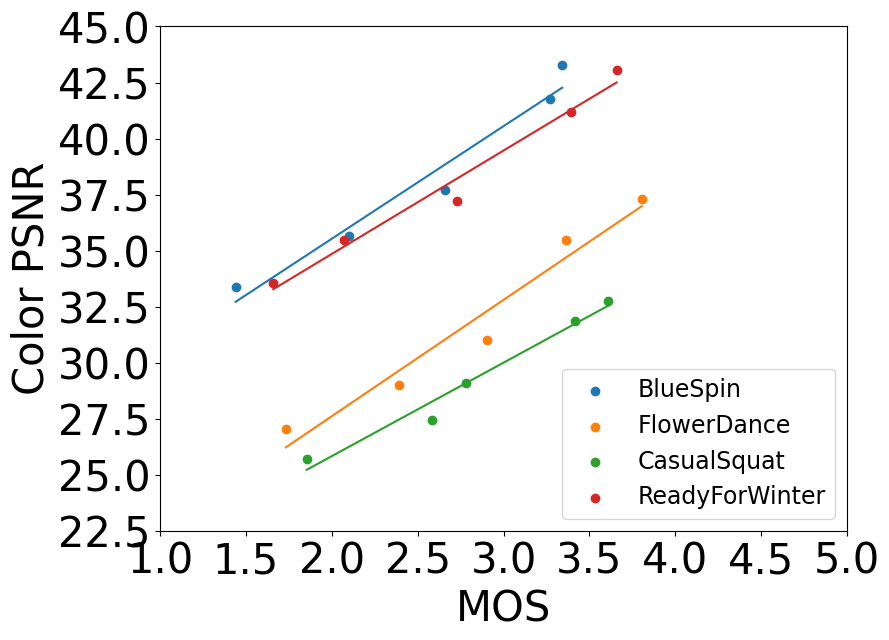

[[1.4390243902439024, 2.097560975609756, 2.658536585365854, 3.268292682926829, 3.341463414634146], [1.7317073170731707, 2.3902439024390243, 2.902439024390244, 3.3658536585365852, 3.8048780487804876], [1.853658536585366, 2.5853658536585367, 2.7804878048780486, 3.4146341463414633, 3.6097560975609757], [1.6585365853658536, 2.073170731707317, 2.731707317073171, 3.3902439024390243, 3.658536585365854]]


[[np.float64(3.88294693312), np.float64(6.12683189496), np.float64(7.989103254800001), np.float64(10.654058064400001), np.float64(11.3115355736)], [np.float64(3.9870719731199995), np.float64(6.1880728313199995), np.float64(7.94226487056), np.float64(10.45159276884), np.float64(11.03222101868)], [np.float64(3.8693299105200003), np.float64(5.62293159676), np.float64(7.011719105), np.float64(8.872019418359999), np.float64(9.344084079240002)], [np.float64(3.8589697706000003), np.float64(6.0712380783199995), np.float64(7.88689097384), np.float64(10.4751840812), np.float64(11.104825691999999)]]
3.

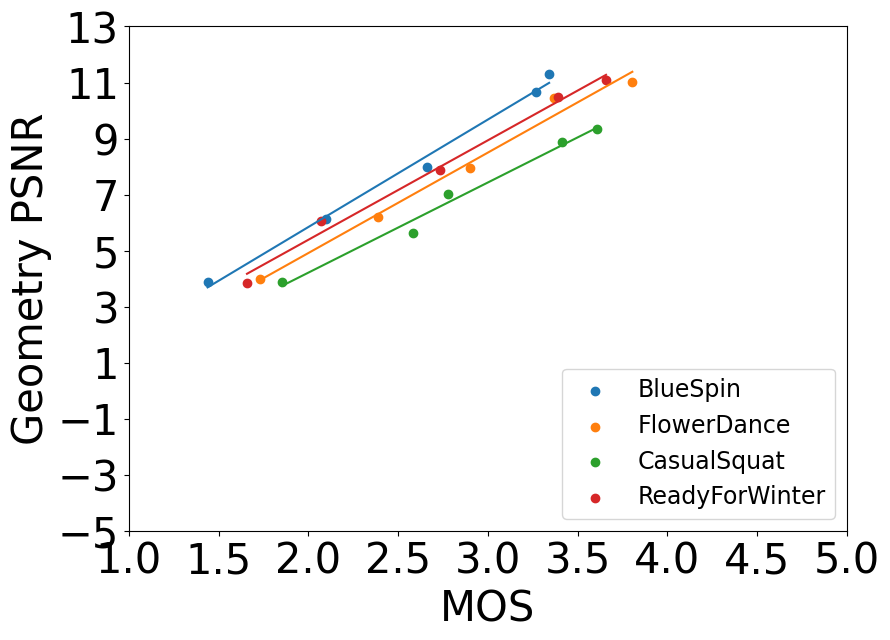

GPCC_OCTREE
[[1.5365853658536586, 1.975609756097561, 2.682926829268293], [1.3902439024390243, 1.975609756097561, 3.317073170731707], [1.4390243902439024, 2.097560975609756, 3.5121951219512195], [1.4634146341463414, 2.097560975609756, 3]]


[[np.float64(32.5639225362), np.float64(37.7783007239), np.float64(41.2244442965)], [np.float64(26.37934586845), np.float64(30.509760019499996), np.float64(34.13071163725)], [np.float64(23.6076054354), np.float64(27.07623403625), np.float64(30.541825760650003)], [np.float64(33.041991306099995), np.float64(37.33985639109999), np.float64(40.5980475766)]]
7.301274819929502 22.111459882589504
3.7935630103436937 21.889237834951455
3.2025717278017662 19.550480042191793
4.8289813029123785 26.432355575141198


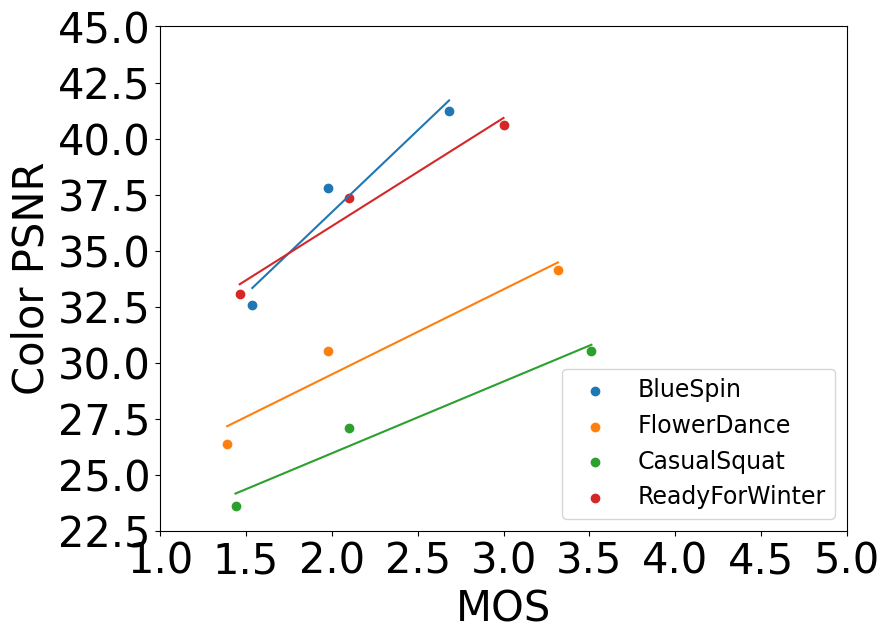

[[1.5365853658536586, 1.975609756097561, 2.682926829268293], [1.3902439024390243, 1.975609756097561, 3.317073170731707], [1.4390243902439024, 2.097560975609756, 3.5121951219512195], [1.4634146341463414, 2.097560975609756, 3]]


[[np.float64(-1.7528400527599999), np.float64(3.01425853596), np.float64(7.78958502824)], [np.float64(-1.734006221), np.float64(3.0369295461600005), np.float64(7.80841888456)], [np.float64(-1.7508477137200003), np.float64(2.99426529708), np.float64(7.79157738516)], [np.float64(-1.75291210128), np.float64(2.9858098774), np.float64(7.7895130002799995)]]
8.17552907198675 -13.865798701752805
4.710650698017303 -7.456530574457085
4.4103374905466195 -7.350835293159779
6.150112953776407 -10.442776770190681


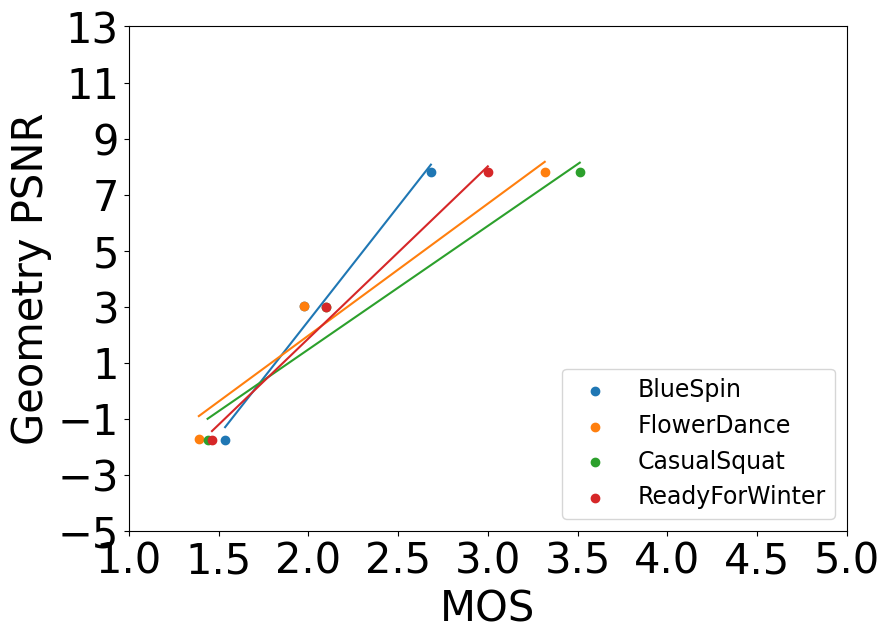

GPCC_TRISOUP
[[1.3658536585365855, 2.317073170731707, 3.1707317073170733, 3.6097560975609757], [1.3902439024390243, 2.5609756097560976, 3.4390243902439024, 3.902439024390244], [1.3658536585365855, 2.4390243902439024, 3.4634146341463414, 3.6341463414634148], [1.2926829268292683, 2.268292682926829, 3.024390243902439, 3.5121951219512195]]


[[np.float64(33.2100758596), np.float64(38.027947749300004), np.float64(41.663919802749994), np.float64(44.1678385123)], [np.float64(27.96984166265), np.float64(31.75853062535), np.float64(35.4027211337), np.float64(38.216248653950004)], [np.float64(26.142529778249997), np.float64(29.71231122345), np.float64(32.6628973768), np.float64(34.963613813150005)], [np.float64(33.5361543407), np.float64(37.61302026425), np.float64(40.983411850349995), np.float64(43.71205470465)]]
4.7980682644674015 26.716401057472176
3.994088304094848 22.06084231893743
3.575425869822496 21.125122414920696
4.53323696486158 27.51750112259303


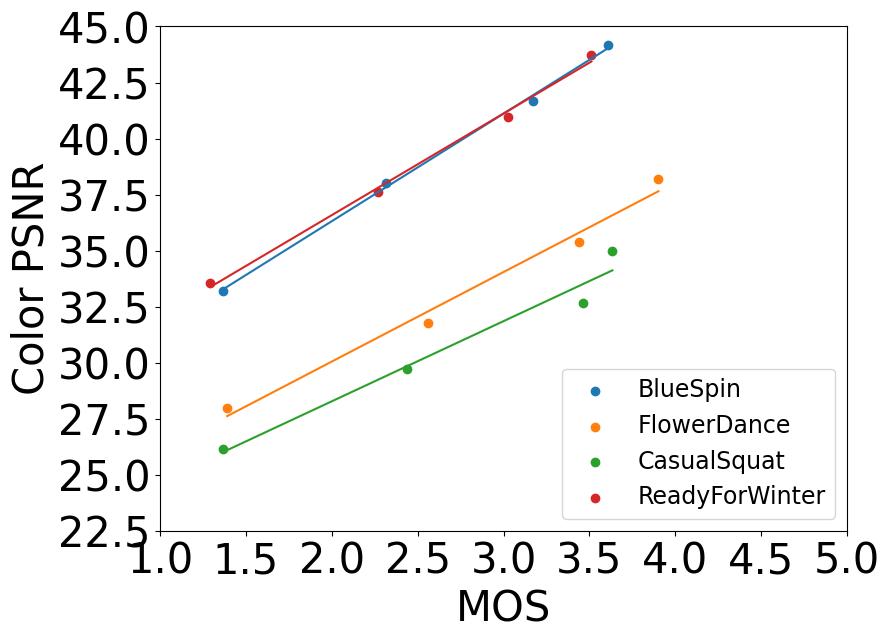

[[1.3658536585365855, 2.317073170731707, 3.1707317073170733, 3.6097560975609757], [1.3902439024390243, 2.5609756097560976, 3.4390243902439024, 3.902439024390244], [1.3658536585365855, 2.4390243902439024, 3.4634146341463414, 3.6341463414634148], [1.2926829268292683, 2.268292682926829, 3.024390243902439, 3.5121951219512195]]


[[np.float64(-3.792735076248), np.float64(3.88240537616), np.float64(8.891416145400001), np.float64(10.9681223792)], [np.float64(-4.39380423236), np.float64(3.3404723445199997), np.float64(8.7281541474), np.float64(10.91337796)], [np.float64(-3.75360492788), np.float64(4.04651113252), np.float64(8.78256314556), np.float64(10.8431652108)], [np.float64(-4.1746414740799995), np.float64(3.4119856976), np.float64(8.891454092560002), np.float64(10.998861294400001)]]
6.5872153697885825 -12.243889218501888
6.157426522879526 -12.73641628714183
6.142499434158197 -11.762397744315335
6.971322108327409 -12.816422614743095


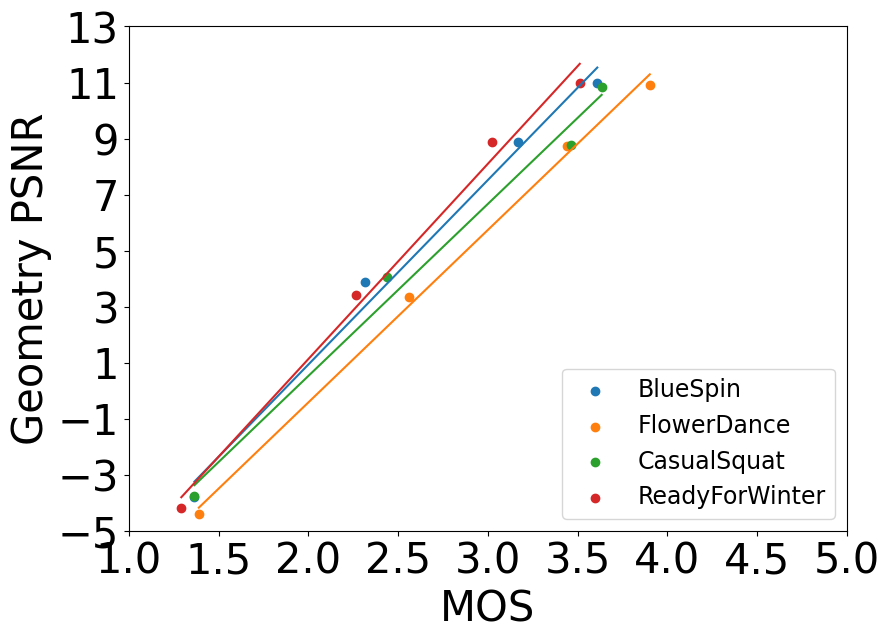

In [ ]:
# PSNR Calculation

import seaborn as sns

for CURRENT_CODEC in codecs:
    print(CURRENT_CODEC)

    psnr_color = {}
    psnr_geometry = {}

    for video in videos:
        psnr_color[video] = {}
        psnr_geometry[video] = {}
        for quality in get_qualities_for_codec(CURRENT_CODEC):
            file = "{}/{}_{}_{}.txt".format(error_data_folder, CURRENT_CODEC, video, quality)
            psnr_color[video][quality], psnr_geometry[video][quality] = calculate_frame_psnr(file)


    video_psnr_color = {}
    video_psnr_geometry = {}

    # Also writing PSNR to files here.

    f = open(os.path.join(results_folder,CURRENT_CODEC + "_color_PSNR.txt"), "w")


    for video in videos:
        video_psnr_color[video] = []
        for qual in get_qualities_for_codec(CURRENT_CODEC):
            psnr_frames_color = psnr_color[video][qual]
            video_psnr_color[video].append(np.average(psnr_frames_color))
            #print("{}_{}_{}_color: {}".format(CURRENT_CODEC, video, qual, np.average(psnr_frames_color)))
            f.write("{}_{}_{}_color: {} \n".format(CURRENT_CODEC, video, qual, np.average(psnr_frames_color)))

    f.close()

    f = open(os.path.join(results_folder,CURRENT_CODEC + "_geometry_PSNR.txt"), "w")

    for video in videos:
        video_psnr_geometry[video] = []
        for qual in get_qualities_for_codec(CURRENT_CODEC):
            psnr_frames_geometry = psnr_geometry[video][qual]
            video_psnr_geometry[video].append(np.average(psnr_frames_geometry))
            #print("{}_{}_{}_geometry: {}".format(CURRENT_CODEC, video, qual, np.average(psnr_frames_geometry)))
            f.write("{}_{}_{}_geometry: {} \n".format(CURRENT_CODEC, video, qual, np.average(psnr_frames_geometry)))

    f.close()


    # Color PSNR vs MOS

    x = [list(mos_new[CURRENT_CODEC][videos[0]].values()), list(mos_new[CURRENT_CODEC][videos[1]].values()), list(mos_new[CURRENT_CODEC][videos[2]].values()), list(mos_new[CURRENT_CODEC][videos[3]].values())]

    print(x)

    print("\n")

    y = [video_psnr_color[videos[0]], video_psnr_color[videos[1]], video_psnr_color[videos[2]], video_psnr_color[videos[3]]]

    print(y)



    #PSNRPlot(x, y, results_folder, CURRENT_CODEC + "_" + "PSNR_color",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Color PSNR", "MOS", outputSuffix="")
    PSNRPlot(x, y, results_folder, CURRENT_CODEC + "_" + "PSNR_color",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "MOS", "cPSNR", "line", x_lim=[1,5], x_interval=0.5, y_lim=[22.5, 45], y_interval=2.5, outputSuffix="_to5")


    # Geometry PSNR vs MOS

    x = [list(mos_new[CURRENT_CODEC][videos[0]].values()), list(mos_new[CURRENT_CODEC][videos[1]].values()), list(mos_new[CURRENT_CODEC][videos[2]].values()), list(mos_new[CURRENT_CODEC][videos[3]].values())]

    print(x)

    print("\n")

    y = [video_psnr_geometry[videos[0]], video_psnr_geometry[videos[1]], video_psnr_geometry[videos[2]], video_psnr_geometry[videos[3]]]

    print(y)


    #PSNRPlot(x, y, results_folder, CURRENT_CODEC + "_" + "PSNR_geometry",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Geometry PSNR", "MOS", outputSuffix="")
    PSNRPlot(x, y, results_folder, CURRENT_CODEC + "_" + "PSNR_geometry",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "MOS", "gPSNR",  x_lim=[1,5], x_interval=0.5, y_lim=[-5, 13], y_interval=2, outputSuffix="_to5")


    # # Correlations
    # mos = np.concatenate([np.array(list(mos_new[CURRENT_CODEC][videos[0]].values())), 
    #                     np.array(list(mos_new[CURRENT_CODEC][videos[1]].values())),
    #                     np.array(list(mos_new[CURRENT_CODEC][videos[2]].values())),
    #                     np.array(list(mos_new[CURRENT_CODEC][videos[3]].values()))
    #                     ], 
    #                     axis=None)

    # cPSNR = np.concatenate([
    #     np.array(video_psnr_color[videos[0]]), 
    #     np.array(video_psnr_color[videos[1]]), 
    #     np.array(video_psnr_color[videos[2]]), 
    #     np.array(video_psnr_color[videos[3]])
    #     ], 
    #     axis=None)

    # gPSNR = np.concatenate([
    #     np.array(video_psnr_geometry[videos[0]]), 
    #     np.array(video_psnr_geometry[videos[1]]), 
    #     np.array(video_psnr_geometry[videos[2]]), 
    #     np.array(video_psnr_geometry[videos[3]])
    #     ], 
    #     axis=None)

    # print(A)
    # print(B)
    # print(C)

    # df_correlation = pd.DataFrame({'MOS': mos,
    #                             'cPSNR': cPSNR,
    #                             'gPSNR': gPSNR})

    # corr = df_correlation.corr(method = 'spearman')

    # sns.heatmap(corr, cmap="YlGnBu", annot=True)
    # plt.savefig(os.path.join(results_folder, CURRENT_CODEC + "_" + "MOS_PSNR_CORRELATION_SPEARMAN.pdf"))
    # plt.savefig(os.path.join(results_folder, CURRENT_CODEC + "_" + "MOS_PSNR_CORRELATION_SPEARMAN.png"))
    # plt.show()

    # spear_corr = df_correlation.corr(method='spearman')
    # pear_corr = df_correlation.corr(method='pearson')

    # corrs = [spear_corr, pear_corr]
    # print('Spearman')
    # print(spear_corr['MOS'])
    # print('Pearson')
    # print(pear_corr['MOS'])

    # fig, axn = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]), figsize=(9,4))

    # sns.heatmap(corrs[0], cmap='YlGnBu', annot = True, cbar=False, ax=axn[0])
    # sns.heatmap(corrs[1], cmap='YlGnBu', annot = True, cbar=False, ax=axn[1])

    # fig.colorbar(axn[1].collections[0], cax=axn[2])
    # axn[0].set_title("Spearman")
    # axn[1].set_title("Pearson")

    # plt.savefig(os.path.join(results_folder, CURRENT_CODEC + "_" + "MOS_PSNR_CORRELATION_BOTH.pdf"))
    # plt.savefig(os.path.join(results_folder, CURRENT_CODEC + "_" + "MOS_PSNR_CORRELATION_BOTH.png"))
    # plt.show()

    # plt.show()


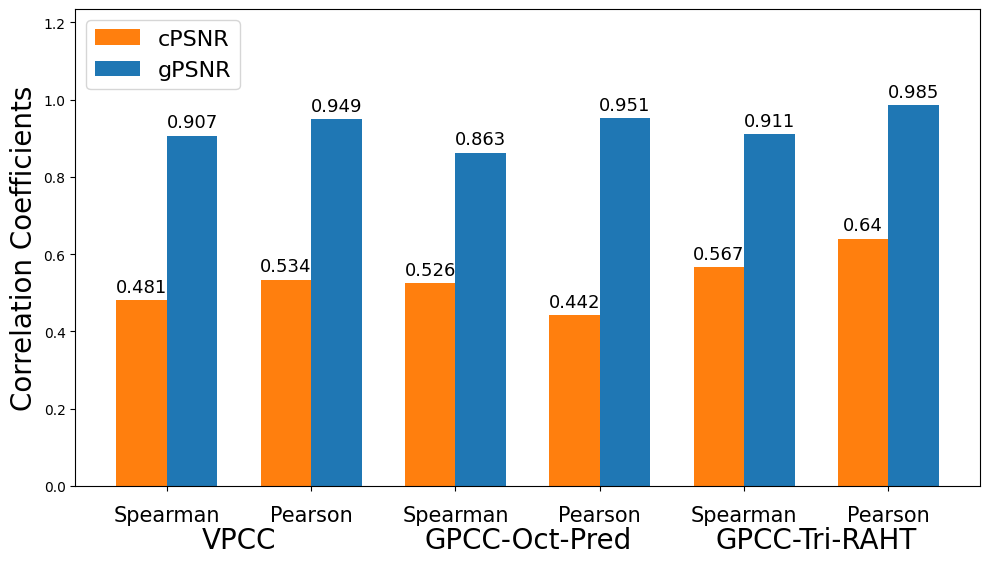

In [140]:
# BAR CHART
n_pairs = 6  # 6 pairs of bars
bar_width = 0.35
x = np.arange(n_pairs)
labels = ['Spearman', 'Pearson'] * (n_pairs // 2) + (['Spearman', 'Pearson'] if n_pairs % 2 else [])

# Example values for each bar
# Each pair: (orange, blue)
cPSNR_values = [0.481, 0.534, 0.526, 0.442, 0.567, 0.640]
gPSNR_values = [0.907, 0.949, 0.863, 0.951, 0.911, 0.985]

# For 6 pairs, we need 12 bars, so repeat the above for both colors
cPSNR_bars = cPSNR_values
gPSNR_bars = gPSNR_values

fig, ax = plt.subplots(figsize=(10, 6))

# Offsets for grouped bars
index = np.arange(n_pairs)
bar1 = ax.bar(index - bar_width/2, cPSNR_bars, bar_width, color='#ff7f0e', label='cPSNR')
bar2 = ax.bar(index + bar_width/2, gPSNR_bars, bar_width, color='#1f77b4', label='gPSNR')

# Display values above bars
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.3}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=13)

# X-axis: alternating "Spearman" and "Pearson" labels for each pair
label_pairs = []
for i in range(n_pairs):
    label_pairs.append("Spearman" if i % 2 == 0 else "Pearson")

ax.set_xticks(index)
ax.set_xticklabels(label_pairs, fontsize=15)

# Main x-axis styling
ax.tick_params(axis='x', pad=10)

# Add "Codec" labels (3 total), each centered under a group of two pairs (i.e., 4 bars)
codec_positions = [0.5, 2.5, 4.5]  # centers for each codec block (pairs 0-1, 2-3, 4-5)
codec_labels = ['VPCC', 'GPCC-Oct-Pred', 'GPCC-Tri-RAHT']

# Draw codec labels below x-tick labels without a horizontal line
ymin, ymax = ax.get_ylim()
label_y = ymin - 0.1 * (ymax - ymin)
for pos, label in zip(codec_positions, codec_labels):
    ax.text(pos, label_y, label, ha='center', va='top', fontsize=20)

# Adjust plot limits and x-tick label padding to make space for codec labels
ax.set_ylim([ymin, ymax+0.2])
ax.tick_params(axis='x', pad=10)

# Legend
ax.legend(loc='upper left',fontsize=16)

ax.set_ylabel('Correlation Coefficients', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)  # More space at bottom for codec labels
plt.savefig(os.path.join(results_folder, 'ALL_CODECS' + "_" + "MOS_PSNR_CORRELATION_BAR.pdf"))
plt.savefig(os.path.join(results_folder, 'ALL_CODECS' + "_" + "MOS_PSNR_CORRELATION_BAR.png"))
plt.show()

VPCC
[[14.0, 18.0, 25.0, 60.0, 100.0], [21.0, 33.0, 57.0, 182.0, 314.0], [20.0, 31.0, 53.0, 156.0, 248.0], [15.0, 20.0, 28.0, 74.0, 132.0]]
[[1.4390243902439024, 2.097560975609756, 2.658536585365854, 3.268292682926829, 3.341463414634146], [1.7317073170731707, 2.3902439024390243, 2.902439024390244, 3.3658536585365852, 3.8048780487804876], [1.853658536585366, 2.5853658536585367, 2.7804878048780486, 3.4146341463414633, 3.6097560975609757], [1.6585365853658536, 2.073170731707317, 2.731707317073171, 3.3902439024390243, 3.658536585365854]]
0.9052711251703498 -0.5980258574262038
0.6936210555471634 -0.1487456624433588
0.6383768242178856 0.1722840041673134
0.8960921298856017 -0.5634321864120908


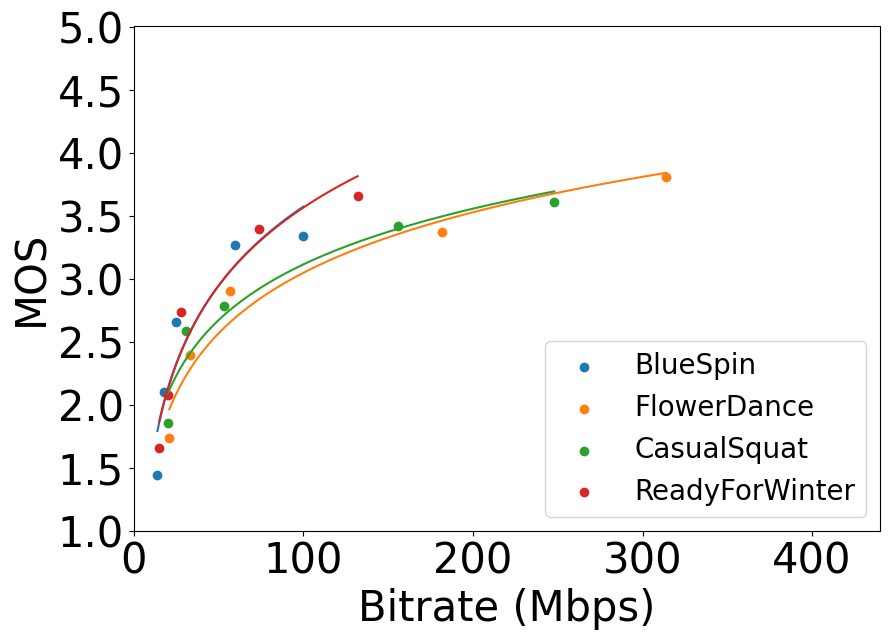

GPCC_OCTREE
[[13.0, 46.0, 109.0], [19.0, 86.0, 250.0], [17.0, 80.0, 236.0], [15.0, 52.0, 134.0]]
[[1.5365853658536586, 1.975609756097561, 2.682926829268293], [1.3902439024390243, 1.975609756097561, 3.317073170731707], [1.4390243902439024, 2.097560975609756, 3.5121951219512195], [1.4634146341463414, 2.097560975609756, 3]]
0.5249465685945592 0.12537381702522862
0.7237689722338336 -0.8894490676068778
0.7630677297271924 -0.8754033444245657
0.6919416331615253 -0.47862879029132227


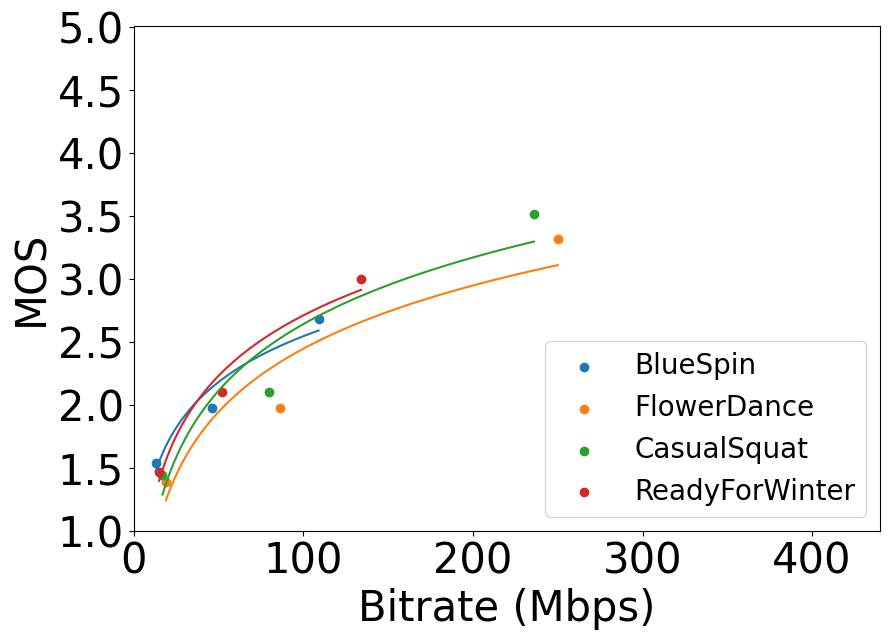

GPCC_TRISOUP
[[9.0, 21.0, 48.0, 109.0], [30.0, 80.0, 190.0, 399.0], [38.0, 92.0, 197.0, 387.0], [9.0, 22.0, 60.0, 142.0]]
[[1.3658536585365855, 2.317073170731707, 3.1707317073170733, 3.6097560975609757], [1.3902439024390243, 2.5609756097560976, 3.4390243902439024, 3.902439024390244], [1.3658536585365855, 2.4390243902439024, 3.4634146341463414, 3.6341463414634148], [1.2926829268292683, 2.268292682926829, 3.024390243902439, 3.5121951219512195]]
0.9137952977491964 -0.5377215138755649
0.982830339248854 -1.8499933008986669
1.0251746263749049 -2.246744284991908
0.7994908171911771 -0.34147226458458974


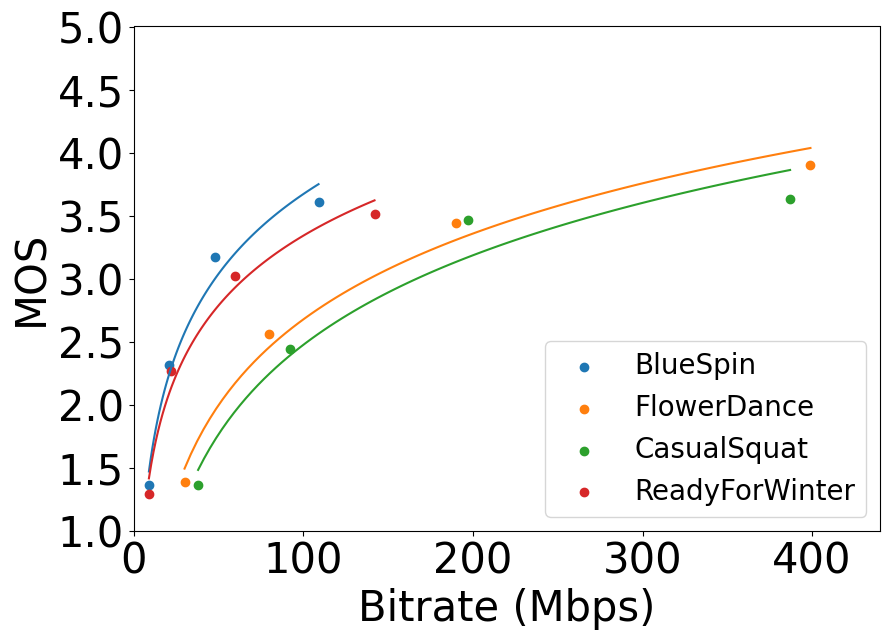

In [141]:
# Bitrate calculation
import os
import glob

for CURRENT_CODEC in codecs:
    print(CURRENT_CODEC)

    keys = ['positions bitstream size', 'colors bitstream size']

    # for video in videos:
    #     if "GPCC_OCTREE" in CURRENT_CODEC:
    #         for quality in qualities_gpcc_octree:
    #             path = "/mnt/d/_work/PointClouds/ComPEQ-MR/gpcc/{}/octree-predlift/{}/*.ply.bin".format(video, quality)
    #             files = glob.glob(path)

    #             num_bytes = 0
    #             for file in files:
    #                 file_size_bytes = os.path.getsize(file)
    #                 num_bytes += file_size_bytes
                
    #             print('{}\t{}\t{}: {}'.format(video, "GPCC_OCTREE", quality, num_bytes*0.008))

    #     elif "GPCC_TRISOUP" in CURRENT_CODEC:
    #         for quality in qualities_gpcc_trisoup:
    #             path = "/mnt/d/_work/PointClouds/ComPEQ-MR/gpcc/{}/trisoup-raht/{}/*.ply.bin".format(video, quality)
    #             files = glob.glob(path)

    #             num_bytes = 0
    #             for file in files:
    #                 file_size_bytes = os.path.getsize(file)
    #                 num_bytes += file_size_bytes

    #             print('{}\t{}\t{}: {}'.format(video, "GPCC_TRISOUP", quality, num_bytes*0.008))

    # Bitrate vs MOS

    y = [list(mos_new[CURRENT_CODEC][videos[0]].values()), list(mos_new[CURRENT_CODEC][videos[1]].values()), list
    (mos_new[CURRENT_CODEC][videos[2]].values()), list(mos_new[CURRENT_CODEC][videos[3]].values())]

    if "VPCC" in CURRENT_CODEC:
        current_bitrates = bitrates_kbps_new_vpcc
    elif "GPCC_OCTREE" in CURRENT_CODEC:
        current_bitrates = bitrates_kbps_new_gpcc_octree
    elif "GPCC_TRISOUP" in CURRENT_CODEC:
        current_bitrates = bitrates_kbps_new_gpcc_trisoup



    x = [list(current_bitrates["BlueSpin"].values()), list(current_bitrates["FlowerDance"].values()), list(current_bitrates["CasualSquat"].values()), list(current_bitrates["ReadyForWinter"].values())]

    x[0] = [ y // 1000 for y in x[0]]
    x[1] = [ y // 1000 for y in x[1]]
    x[2] = [ y // 1000 for y in x[2]]
    x[3] = [ y // 1000 for y in x[3]]

    print(x)
    print(y)

    #linePlot(x, y, results_folder, CURRENT_CODEC + "_" + "Bitrates_vs_MOS",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Bitrate (Mbps)", "MOS", "line", [0,500], [1,5], outputSuffix="")
    #linePlot(x, y, results_folder, CURRENT_CODEC + "_" + "Bitrates_vs_MOS",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Bitrate (Mbps)", "MOS", "log", None, None, "_log")
    linePlot(x, y, results_folder, CURRENT_CODEC + "_" + "Bitrates_vs_MOS",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Bitrate (Mbps)", "MOS", "log", [0,440], [1,5], "_to5_log")
    #linePlot(x, y, results_folder, CURRENT_CODEC + "_" + "Bitrates_vs_MOS",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Bitrate (Mbps)", "MOS", "expo", [0,500], [1,5], "_to5_expo")
    #linePlot(x, y, results_folder, CURRENT_CODEC + "_" + "Bitrates_vs_MOS",["BlueSpin", "FlowerDance", "CasualSquat", "ReadyForWinter"], "Bitrate (Mbps)", "MOS", "cubic", [0,500], [1,5], "_to5_cubic")
